# Imports

In [1]:
import pandas as pd
import numpy as np
import inflect
import re
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from nltk.tokenize import word_tokenize,sent_tokenize
import gensim.downloader as api
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import contractions
import unidecode
import demoji
from sklearn.preprocessing import LabelBinarizer
from emot.emo_unicode import UNICODE_EMOJI, UNICODE_EMOJI_ALIAS, EMOTICONS_EMO
from flashtext import KeywordProcessor
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Bidirectional,LSTM,Embedding, GlobalMaxPooling1D, GlobalMaxPooling3D
from tensorflow.keras.layers import Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tweepy
from pandas import Series,DataFrame
import pandas as pd
import pickle

# Data Import and Visualization

In [9]:
df = pd.read_csv('https://query.data.world/s/5xzuftmozqteqbqzopbcgxbjzusyi7')

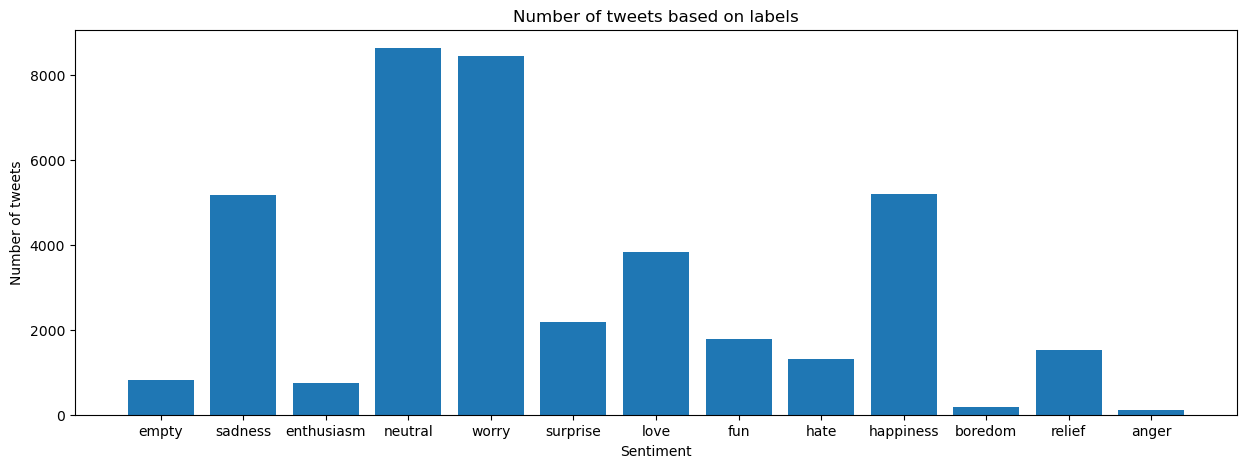

In [10]:
labels = df['sentiment']
data_vis ={}
for label in labels:
    data_vis[label] = data_vis.get(label, 0) + 1
fig = plt.figure(figsize = (15, 5))
sentiments = list(data_vis.keys())
values = list(data_vis.values())
# creating the bar plot
plt.bar(sentiments, values)
plt.xlabel("Sentiment")
plt.ylabel("Number of tweets")
plt.title("Number of tweets based on labels")
plt.show()

# Removing the unwanted labels and encoding the remaining labels

In [11]:
#converting our  above emotions to the labels and dropping the content
#df['sentiment'] = df['sentiment'].replace(labels)
#df['content']= list(map(lambda x: x.lower(), df['processed']))
df.drop(index=df[df['sentiment'] == 'love'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'surprise'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'relief'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'boredom'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'worry'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'anger'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'hate'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'empty'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'enthusiasm'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'fun'].index, inplace=True)
df.drop(index=df[df['sentiment'] == 'neutral'].index, inplace=True)
encoder = LabelBinarizer()
encoder.fit(df.sentiment.unique())
with open("encoder", "wb") as file:
    pickle.dump(encoder, file)

# Preprocessing the data

In [12]:
#reomve pattern function, input_text is the text we want to process, the pattern is the pattern we want to remove
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

In [13]:
all_emoji_emoticons = {**EMOTICONS_EMO,**UNICODE_EMOJI_ALIAS, **UNICODE_EMOJI_ALIAS}
all_emoji_emoticons = {k:v.replace(":","").replace("_"," ").strip() for k,v in all_emoji_emoticons.items()}
kp_all_emoji_emoticons = KeywordProcessor()
for k,v in all_emoji_emoticons.items():
    kp_all_emoji_emoticons.add_keyword(k, v)

In [14]:
#preprocess the data
replacers = {'dm': 'direct message',
 'thx': 'thanks',
 'dming': 'direct messaging',
 'dmed': 'direct messaged',
 'plz': 'please',
 'u': 'you',
 'asap': 'as soon as possible',
 '...': '',
 '. . .': '',
 'r': 'are', 
 'tho': 'though', 'wassup' : 'whats up', 'lol': 'laughing out loud', 'layin': 'laying', 'y' :'why', 'bd' : 'birthday',
  'btw': 'by the way', 'ty': 'thank you', 'brb': 'be right back', 'omg': 'oh my god', 'yup' : 'yes', 'yep' : 'yes'}
def preprocess(df):
    #remove the @
    df['processed'] = np.vectorize(remove_pattern)(df['content'], "@[\w]*")
    
    #convert to lower case
    df.loc[:, 'processed'] = df.loc[:, 'processed'].str.lower()
    
    #converting don't -> do not
    removed = []
    for text in df['processed']:
        txt =[]
        for word in text.split():
            txt.append(contractions.fix(word))
        ex_txt = ' '.join(txt)
        removed.append(ex_txt)
    df.drop('processed', axis = 1, inplace = True)
    df['processed'] = removed
    
    #remove any links
    df['processed'] = df['processed'].str.replace('http[^\s]*',"")
    
    #convert emoji to text
    pr = []
    for text in df['processed']:
        pr.append(kp_all_emoji_emoticons.replace_keywords(text))
    df.drop('processed', axis = 1, inplace = True)
    df['processed'] = pr
    
    #remove the #
    df['processed'] = np.vectorize(remove_pattern)(df['processed'], "#")
    
    # converting unicode to ascii
    stemmer = PorterStemmer()
    removed = []
    for text in df['processed']:
        removed.append(unidecode.unidecode(text))
    df.drop('processed', axis = 1, inplace = True)
    df['processed'] = removed
    
    #remove the special characters, numbers, punctuations
    df['processed'] = df['processed'].str.replace("[^a-zA-Z#]", " ",regex=True)
    
    #converting common acronyms to common words
    df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))
    
     #remove the words smaller than 2
    #df['processed'] = df['processed'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
    
    #remove white spaces
    df['processed'] = df['processed'].str.strip()
    
    return df

In [15]:
df_x = df
df_y = df['sentiment']
df_x

,tweet_id,sentiment,author,content
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ..."
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?
...,...,...,...,...
39986,1753905153,happiness,sue_jr,going to watch boy in the striped pj's hope i ...
39987,1753918809,happiness,njohari,"gave the bikes a thorough wash, degrease it an..."
39988,1753918818,happiness,RachellSmithles,"had SUCH and AMAZING time last night, McFly we..."
39994,1753918900,happiness,courtside101,Succesfully following Tayla!!


In [16]:
x_train, x_rem, y_train, y_rem = train_test_split(df_x, df_y, test_size=0.5)
x_test_t, x_valid_t, y_test, y_valid = train_test_split(x_rem, y_rem, test_size=0.5)
df_processed_x = preprocess(x_train)
#convert the labels into categroical data using the keras library
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
y_valid = encoder.transform(y_valid)
#The output of the y_train and y_test will be a binary matrix and has columns equal to the number of categories in the data.
df_processed_x
y_train

C:\Users\mangu\AppData\Local\Temp\ipykernel_3496\1721477037.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'].str.replace('http[^\s]*',"")
C:\Users\mangu\AppData\Local\Temp\ipykernel_3496\1721477037.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))


array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [17]:
df_processed_x
x_train = df_processed_x['processed']
x_test = x_test_t['content']
x_valid = x_valid_t['content']

In [18]:
df_processed_x['processed'].iloc[[190]]

22985    from me and no one else muhahahaaaa well maybe...
Name: processed, dtype: object

In [19]:
x_train.shape

(5187,)

In [20]:
x_test.shape

(2593,)

In [21]:
x_valid.shape

(2594,)

In [22]:
x_train

5760                           thanks lady bummer for sure
31598    i been saying that the past weeks that i miss ...
22416                                 happy juddday carrie
16981                                           rain delay
12183    see wat i mean bout foll w friidays it is call...
                               ...                        
16108    not allowed to call as i live in the uk my par...
7133     i failed at cutting and peeling the mangoes ha...
23996          right i must be off to do some sewing bye x
35436    for some strange reason paranoid sounds like y...
14087    what a day hours work but i would really like ...
Name: processed, Length: 5187, dtype: object

# Tokenizing the data and padding the text

In [23]:
tokenizer = Tokenizer(5000,lower=True)
combi = pd.concat([x_train, x_test], axis = 0)
tokenizer.fit_on_texts(combi)
#Since the BiLSTM model only considers numeric values, we convert our vector of tokens to numeric sequnces, that is each
#token is represented by its frequency in the text
x_seq = tokenizer.texts_to_sequences(x_train)
X_train = pad_sequences(x_seq, maxlen = 34, padding='post')
y_seq = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(y_seq, maxlen = 34, padding='post')
z_seq = tokenizer.texts_to_sequences(x_valid)
X_valid = pad_sequences(z_seq, maxlen = 34, padding='post')
word_index = tokenizer.word_index

# Creating Word Embeddings

In [24]:
# Glove vector contains a 50 dimensional vector corresponding to each word in dictionary.
vocab = 'glove.6B.50d.txt'
# embeddings_index is a dictionary which contains the mapping of
# word with its corresponding 50d vector.
embeddings_index = {}
with open(vocab, encoding='utf8') as f:
    for line in f:
        # splitting each line of the glove.6B.50d in a list of items- in which
        # the first element is the word to be embedded, and from second
        # to the end of line contains the 50d vector.
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [25]:
embedding_matrix = np.zeros((len(word_index)+1, 50))
for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        embedding_matrix[index] = np.zeros(50)

# Building the Baseline Model and Predicting the results

In [26]:
#EarlyStopping and ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [34]:
def baseline_model(X,Y, classes):
    model=Sequential()
    model.add(Embedding(input_dim=len(word_index)+1, output_dim=50, input_length=len(X[0]), weights = [embedding_matrix], trainable=False))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(classes, activation = 'softmax'))
    model.add(GlobalMaxPooling1D())
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    ep = model.fit(X, Y, batch_size=64, epochs=10, verbose = 1, validation_data=(X_valid, y_valid))
    return model, ep

In [35]:
#Building the baseline model with only 3 labels
baselineModel, base_his = baseline_model(X_train,y_train, 3)

Epoch 1/10
149/149 [==============================] - 4s 12ms/step - loss: 1.0104 - accuracy: 0.5038 - val_loss: 0.9545 - val_accuracy: 0.5382
Epoch 2/10
149/149 [==============================] - 1s 9ms/step - loss: 0.9204 - accuracy: 0.5696 - val_loss: 0.9283 - val_accuracy: 0.5500
Epoch 3/10
149/149 [==============================] - 1s 9ms/step - loss: 0.8960 - accuracy: 0.5927 - val_loss: 0.9193 - val_accuracy: 0.5746
Epoch 4/10
149/149 [==============================] - 1s 9ms/step - loss: 0.8873 - accuracy: 0.6066 - val_loss: 0.9377 - val_accuracy: 0.5841
Epoch 5/10
149/149 [==============================] - 1s 9ms/step - loss: 0.8772 - accuracy: 0.6076 - val_loss: 0.9168 - val_accuracy: 0.5996
Epoch 6/10
149/149 [==============================] - 1s 9ms/step - loss: 0.8702 - accuracy: 0.6177 - val_loss: 0.9107 - val_accuracy: 0.6028
Epoch 7/10
149/149 [==============================] - 1s 9ms/step - loss: 0.8641 - accuracy: 0.6193 - val_loss: 0.9309 - val_accuracy: 0.6011
Epoch

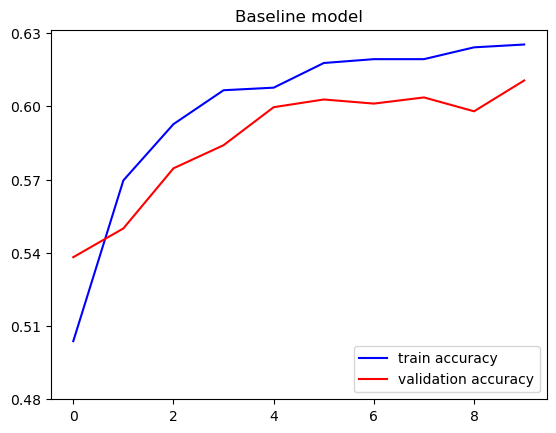

In [36]:
#Predicting with only 3 labels - Baseline Model
plt.plot(base_his.history['accuracy'],c='b',label='train accuracy')
plt.plot(base_his.history['val_accuracy'],c='r',label='validation accuracy')
plt.title("Baseline model")
plt.yticks(np.arange(0.48, 0.65, 0.03))
plt.legend(loc='lower right')
plt.show()

In [37]:
#Results with only 3 labels - Baseline Model
y_pred = np.argmax(baselineModel.predict(X_test), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

149/149 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.60      0.58      0.59      1369
           1       0.72      0.62      0.67      2502
           2       0.47      0.68      0.56       882

    accuracy                           0.62      4753
   macro avg       0.60      0.63      0.60      4753
weighted avg       0.64      0.62      0.62      4753



# Building the BiLSTM Model and Predicting the results

In [27]:
def build_model(X,Y, classes):
    #Dimension of our embeddings
    embedding_dim = 50
    model=Sequential()
    model.add(Embedding(input_dim=len(word_index)+1, output_dim=50, input_length=len(X[0]), weights = [embedding_matrix], trainable=False))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(classes, activation = 'softmax'))
    adam = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    ep = model.fit(X, Y, batch_size=128, epochs=25, verbose = 1, validation_data=(X_valid, y_valid), callbacks= [es, mc])
    return model, ep

In [28]:
#Building model with only 3 labels
bilstmModel, his=build_model(X_train,y_train, 2)

Epoch 1/25
41/41 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.5855
Epoch 1: val_accuracy improved from -inf to 0.64148, saving model to .\model.h5
41/41 [==============================] - 242s 3s/step - loss: 0.6758 - accuracy: 0.5855 - val_loss: 0.6455 - val_accuracy: 0.6415
Epoch 2/25
41/41 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.6723
Epoch 2: val_accuracy improved from 0.64148 to 0.70817, saving model to .\model.h5
41/41 [==============================] - 112s 3s/step - loss: 0.6204 - accuracy: 0.6723 - val_loss: 0.5856 - val_accuracy: 0.7082
Epoch 3/25
41/41 [==============================] - ETA: 0s - loss: 0.5926 - accuracy: 0.6885
Epoch 3: val_accuracy did not improve from 0.70817
41/41 [==============================] - 111s 3s/step - loss: 0.5926 - accuracy: 0.6885 - val_loss: 0.5703 - val_accuracy: 0.7012
Epoch 4/25
41/41 [==============================] - ETA: 0s - loss: 0.5824 - accuracy: 0.6933
Epoch 4: val_accurac

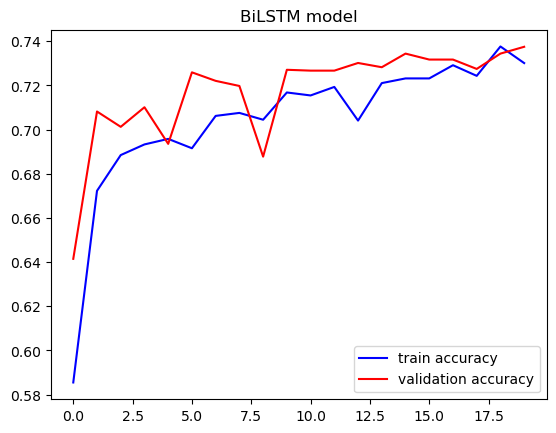

In [31]:
#Predicting with only 3 labels - bilstm model
plt.plot(his.history['accuracy'],c='b',label='train accuracy')
plt.plot(his.history['val_accuracy'],c='r',label='validation accuracy')
plt.title("BiLSTM model")
plt.legend(loc='lower right')
plt.show()

In [32]:
#Results with only 3 labels - bilstm model
y_pred =   np.argmax(bilstmModel.predict(X_test), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

82/82 [==============================] - 35s 431ms/step
              precision    recall  f1-score   support

           0       0.43      1.00      0.60      1107
           1       0.00      0.00      0.00      1486

    accuracy                           0.43      2593
   macro avg       0.21      0.50      0.30      2593
weighted avg       0.18      0.43      0.26      2593



C:\Users\mangu\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mangu\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mangu\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Extracting the tweets

In [33]:
#Put your Bearer Token in the parenthesis below
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAHiaigEAAAAA1hzpI79DUjAi9q8PvGD7lfTzWjQ%3Dw9PNTdJGBWQOWxJjY9l5yP1Z7fglAF5SQGbLN6LrzUHQ5Gvbkd')

# Get tweets that contain the hashtag #petday
# -is:retweet means I don't want retweets
# lang:en is asking for the tweets to be in english
query = 'covid -is:retweet'
tweets = client.search_recent_tweets(query = query, tweet_fields=['context_annotations', 'created_at'], max_results=100)

tweet_lst = [tweet.text for tweet in tweets.data]



data = {'content': tweet_lst}
tweet_df = DataFrame(data)
tweet_pro = preprocess(tweet_df)
tweet_pro

C:\Users\mangu\AppData\Local\Temp\ipykernel_3496\1721477037.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'].str.replace('http[^\s]*',"")
C:\Users\mangu\AppData\Local\Temp\ipykernel_3496\1721477037.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))


,content,processed
0,@RepMTG What a bout all the LIES &amp; MISINFO...,what a bout all the lies amp misinformation ab...
1,@souplifebond どちらを取るかですよね。重症化予防効果も残るけど減弱する、追加接...,dochirawoQu rukadesuyone Zhong Zheng Hua Yu Fa...
2,@tedcruz While MAGA remains misinformed about ...,while maga remains misinformed about covid mas...
3,@randomjeweler @roxiqt I remember trying to ex...,i remember trying to explain to someone that t...
4,$AAPL - Apple is accelerating plans to move pr...,aapl apple is accelerating plans to move produ...
...,...,...
95,"@johnstodder @mtaibbi Btw, 2020 was just anoth...",by the way was just another fraudulent electio...
96,.\n\nL'oxyde de graphène hautement toxique\nes...,l oxyde de graphene hautement toxique est acti...
97,@nfergus How does zero COVID get you 5% growth?,how does zero covid get you growth
98,they originally titled their presentation ‘No ...,they originally titled their presentation no c...


In [34]:
x_dat = tweet_pro['processed']
x_dat

0     what a bout all the lies amp misinformation ab...
1     dochirawoQu rukadesuyone Zhong Zheng Hua Yu Fa...
2     while maga remains misinformed about covid mas...
3     i remember trying to explain to someone that t...
4     aapl apple is accelerating plans to move produ...
                            ...                        
95    by the way was just another fraudulent electio...
96    l oxyde de graphene hautement toxique est acti...
97                   how does zero covid get you growth
98    they originally titled their presentation no c...
99    parana confirma mais casos e uma morte por cov...
Name: processed, Length: 100, dtype: object

# Predicting the emotion from tweets

In [35]:
x_seq = tokenizer.texts_to_sequences(x_dat)
x_data = pad_sequences(x_seq, maxlen = 34, padding='post')
y_pred = bilstmModel.predict(x_data)

4/4 [==============================] - 1s 266ms/step


In [36]:
#Building model with only 3 labels
with open('encoder', 'rb') as file:
    encoder = pickle.load(file)
for index, value in enumerate(np.sum(y_pred, axis=0) / len(y_pred)):
    print(encoder.classes_[index] + ": " + str(value))

happiness: 0.34042454
sadness: 0.6595753


# Extracting the tweets - Happy

In [37]:
#Put your Bearer Token in the parenthesis below
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAHiaigEAAAAA1hzpI79DUjAi9q8PvGD7lfTzWjQ%3Dw9PNTdJGBWQOWxJjY9l5yP1Z7fglAF5SQGbLN6LrzUHQ5Gvbkd')

# Get tweets that contain the hashtag #petday
# -is:retweet means I don't want retweets
# lang:en is asking for the tweets to be in english
query = 'happy -is:retweet'
tweets = client.search_recent_tweets(query = query, tweet_fields=['context_annotations', 'created_at'], max_results=100)

tweet_lst = [tweet.text for tweet in tweets.data]



data = {'content': tweet_lst}
tweet_df = DataFrame(data)
tweet_pro = preprocess(tweet_df)
tweet_pro

C:\Users\mangu\AppData\Local\Temp\ipykernel_3496\1721477037.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'].str.replace('http[^\s]*',"")
C:\Users\mangu\AppData\Local\Temp\ipykernel_3496\1721477037.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))


,content,processed
0,"Nah, I am very happy rn. I am proud to be a CI...",nah i am very happy right now i am proud to be...
1,Im so happy my appetite coming back. I’ve been...,i am so happy my appetite coming back i have b...
2,I’m old enough to remember when Commanders fan...,i am old enough to remember when commanders fa...
3,"she was happy. Later, https://t.co/BTmUyA9bmR",she was happy later
4,#CamdakiKız i was so happy when nalan left the...,camdakikiz i was so happy when nalan left the ...
...,...,...
93,"Thank you Qantas, but it is “Merry Christmas” ...",thank you qantas but it is merry christmas not...
94,We have helped a lot of people and we are\nhap...,we have helped a lot of people and we are happ...
95,Happy belated birthday my love 💜💜💜 https://t.c...,happy belated birthday my love purple heartpur...
96,… I’m happy. https://t.co/8VpLIsrpkH,i am happy


In [38]:
x_dat = tweet_pro['processed']
x_dat

0     nah i am very happy right now i am proud to be...
1     i am so happy my appetite coming back i have b...
2     i am old enough to remember when commanders fa...
3                                   she was happy later
4     camdakikiz i was so happy when nalan left the ...
                            ...                        
93    thank you qantas but it is merry christmas not...
94    we have helped a lot of people and we are happ...
95    happy belated birthday my love purple heartpur...
96                                           i am happy
97    itsuchiyan ohayosmiling face with hearts Qi Li...
Name: processed, Length: 98, dtype: object

In [39]:
x_seq = tokenizer.texts_to_sequences(x_dat)
x_data = pad_sequences(x_seq, maxlen = 34, padding='post')
y_pred = bilstmModel.predict(x_data)

4/4 [==============================] - 2s 294ms/step


In [40]:
#Building model with only 3 labels
with open('encoder', 'rb') as file:
    encoder = pickle.load(file)
for index, value in enumerate(np.sum(y_pred, axis=0) / len(y_pred)):
    print(encoder.classes_[index] + ": " + str(value))

happiness: 0.6690435
sadness: 0.33095655


#  Extracting the tweets - Sad

In [41]:
#Put your Bearer Token in the parenthesis below
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAHiaigEAAAAA1hzpI79DUjAi9q8PvGD7lfTzWjQ%3Dw9PNTdJGBWQOWxJjY9l5yP1Z7fglAF5SQGbLN6LrzUHQ5Gvbkd')

# Get tweets that contain the hashtag #petday
# -is:retweet means I don't want retweets
# lang:en is asking for the tweets to be in english
query = 'sad -is:retweet'
tweets = client.search_recent_tweets(query = query, tweet_fields=['context_annotations', 'created_at'], max_results=100)

tweet_lst = [tweet.text for tweet in tweets.data]



data = {'content': tweet_lst}
tweet_df = DataFrame(data)
tweet_pro = preprocess(tweet_df)
tweet_pro

C:\Users\mangu\AppData\Local\Temp\ipykernel_3496\1721477037.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'].str.replace('http[^\s]*',"")
C:\Users\mangu\AppData\Local\Temp\ipykernel_3496\1721477037.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))


,content,processed
0,"@obIiquidens @ivanchtototam no, but it was sup...",no but it was super shitty story without actua...
1,it’s sad how y’all body shame people into surg...,it is sad how you all body shame people into s...
2,@Imposter_Edits It’s sad isn’t it? Don’t send ...,it is sad is not it do not send your child if ...
3,@iDallasDoll @3_card_monet @RogerWi54398999 @n...,the fact that people do not feel that the desc...
4,@TheAwkwardDrop @jonkay @SCDSB_Schools He's ju...,he is just a sad miserable person that frequen...
...,...,...
90,"@TheLeoTerrell And losers like you remain, how...",and losers like you remain how sad for our cou...
91,Don’t go out sad behind NOBODY,do not go out sad behind nobody
92,@Dei_Vivid @AJG8919 @MarinaPurkiss Have a good...,have a good look you sad individual
93,@ToughPigs My first album ever was a Sesame St...,my first album ever was a sesame street vinyl ...


In [42]:
x_dat = tweet_pro['processed']
x_dat

0     no but it was super shitty story without actua...
1     it is sad how you all body shame people into s...
2     it is sad is not it do not send your child if ...
3     the fact that people do not feel that the desc...
4     he is just a sad miserable person that frequen...
                            ...                        
90    and losers like you remain how sad for our cou...
91                      do not go out sad behind nobody
92                  have a good look you sad individual
93    my first album ever was a sesame street vinyl ...
94    sad rest in peace ukraine will win flag for Uk...
Name: processed, Length: 95, dtype: object

In [43]:
x_seq = tokenizer.texts_to_sequences(x_dat)
x_data = pad_sequences(x_seq, maxlen = 34, padding='post')
y_pred = bilstmModel.predict(x_data)

3/3 [==============================] - 1s 350ms/step


In [44]:
#Building model with only 3 labels
with open('encoder', 'rb') as file:
    encoder = pickle.load(file)
for index, value in enumerate(np.sum(y_pred, axis=0) / len(y_pred)):
    print(encoder.classes_[index] + ": " + str(value))

happiness: 0.24106605
sadness: 0.758934
